# Курсовая работа по теме "Метод Ланцоша" (код с пояснениями)
# Выполнила: Бабичева Анна
# Группа: М8О-304Б-17

### Задача. Необходимо найти собственные значения симметричной разреженной матрицы большой размерности, используя метод Ланцоша.

## Подготовка

Загружаю необходимые библиотеки. Модуль matrix написан мной и включает в себя наработки из лабораторной работы № 1 с некоторыми изменениями. Модуль mmio взять на просторах интернета и позволяет считывать матрицы с разрешением .mtx.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import matrix
import mmio
import time

from numpy import arange
from copy import deepcopy
from matrix import Matrix

Для работы с разреженными матрицами большой размерности имеет смысл создания отдельного класса разреженных матриц, включающего в себя стандартные операции над матрицами. В методе Ланцоша мне понадобятся матричное умножение и проверка на симметричность.

In [2]:
class R_matrix:
    
    # Разреженная матрица будет представлять собой объект,
    # имеющий список индексов ненулевых элементов,
    # список значений ненулевых элементов, расположенных построчно,
    # а также значние размерности матрицы

# ИНИЦИАЛИЗАЦИЯ
    
    # Инициализация будет возможна по двум сценариям:
    #   1. В качестве аргумента при создании экземпляра класса
    #      подаем объект типа Matrix, указывая при этом mat=...,
    #   2. В качестве аргумента подаем список индексов (inds=...),
    #      список значений (vals=...) и размер матрицы (size=...)

    #   __init__(self, mat, inds, vals, size)   
    
    def __init__(self, **kwargs):
        for name, value in kwargs.items():
            if (type(value) == Matrix) & (len(kwargs.items()) == 1):
                self.size = value.size
                self.inds, self.vals = self._make_inds_vals(value)
            elif (len(kwargs.items()) == 3) & (((name == 'inds') & (type(value) == list)) | (((name == 'vals') & (type(value) == list))) | (((name == 'size') & (type(value) == tuple)))):
                setattr(self, name, value)                    
            else:
                raise Exception("Неверное задание аргументов")

# СКРЫТЫЕ ФУНКЦИИ КЛАССА

    # Функция создания списка индексов и списка значений
    # разреженной матрицы из полученной неразреженной матрицы

    def _make_inds_vals(self, mat):
        inds = []        
        vals = []
        
        for i in range(mat.size[0]):
            rows = []
            for j in range(mat.size[1]):
                if mat.matrix[i][j] != 0:
                    rows.append(j)
                    vals.append(mat.matrix[i][j])
            inds.append(rows)
        return inds, vals
    
    # Функция преобразования списка индексов из списка
    # "строк от столбцов" к списку "столбцов от строк"
    
    def _cols_of_rows(self):
        cols = []
        for j in range(self.size[1]):
            rows = []
            for i, row in enumerate(self.inds): 
                if j in row:
                    rows.append(i)
            cols.append(rows)
        return cols

# МЕТОДЫ КЛАССА

    # УМНОЖЕНИЕ СЛЕВА
    # Функция позволяет получить экземляр класса
    # разреженных матриц после перемножения слева 
    # обычной матрицы и исходного экземляра
    
    def left_multiply(self, mat):
        if self.size[0] != mat.size[1]:
            raise Exception("Несоответствие размерностей:\nm.size = {0}, self.size = {1}".format(mat.size, self.size))
        n = self.size[1]
        m = mat.size[0]
        
        inds = []
        vals = []

        cols = self._cols_of_rows()  

        for i in range(m):
            rows = []
            k = 0
            for j, row in enumerate(cols):
                s = 0
                for l, col in enumerate(row):
                    s += mat.matrix[i][col] * self.vals[k]
                    k += 1
                if s != 0:
                    vals.append(s)
                    rows.append(j)
            inds.append(rows)
        
        if (m == 1) & (n == 1):
            return vals[0]
        return R_matrix(inds=inds, vals=vals, size=(m, n))   
    
    # УМНОЖЕНИЕ СПРАВА
    # Функция позволяет получить экземляр класса
    # разреженных матриц после перемножения справа 
    # обычной матрицы и исходного экземляра
    
    def right_multiply(self, mat):
        if self.size[1] != mat.size[0]:
            raise Exception("Несоответствие размерностей:\nself.size = {0}, m.size = {1}".format(self.size, mat.size))
        m = self.size[0]
        n = mat.size[1]
        
        inds = []
        vals = []
                
        k = 0
        for i, row in enumerate(self.inds):  
            rows = []
            for j in range(n):
                s = 0
                for l, col in enumerate(row):
                    s += self.vals[k + l] * mat.matrix[col][j]
                if s != 0:
                    vals.append(s)
                    rows.append(j)
            inds.append(rows)
            k += len(row)
        if (m == 1) & (n == 1):
            return vals[0]
        return R_matrix(inds=inds, vals=vals, size=(m, n))
    
    # ПОЛУЧЕНИЕ МАТРИЦЫ КЛАССА MATRIX
    # Функция преобразования разреженной матрицы
    # к обычному формату матриц
    
    def make_Matrix(self):
        cols = []
        
        k = 0
        for i in range(self.size[0]):
            rows = []
            for j in range(self.size[1]):
                if j in self.inds[i]:
                    rows.append(self.vals[k])
                    k += 1
                else:
                    rows.append(0)                
            cols.append(rows)
        return Matrix(cols)
    
    # ПРОВЕРКА НА СИММЕТРИЧНОСТЬ
    
    def simmetric(self):
        return Matrix.Simmetric(self.make_Matrix())    

# СТАТИЧЕСКИЕ МЕТОДЫ 
    
    # ЕДИНИЧНАЯ МАТРИЦА
    # Получение разреженной единичной 
    # матрицы заданной размерности
    
    def E(n):
        inds = []
        vals = []
        for i in range(n):
            inds.append([i])
            vals.append(1)
        return R_matrix(inds=inds, vals=vals, size=(n, n))

Я подготовила три разреженных симметричных матрицы разных размерностей.

In [3]:
!ls data

bcsstk01.mtx  bcsstk04.mtx  bcsstk26.mtx


Матрицы имеют соответственно вид: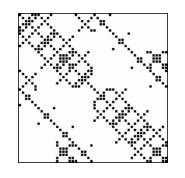

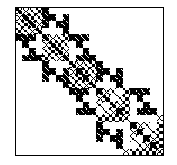

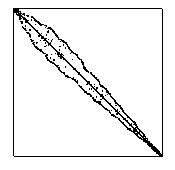

Считываю данные матрицы с помощью модуля mmio и преобразую их к объктам типа Matrix.

In [4]:
m01 = mmio.mmread("data/bcsstk01.mtx").toarray()
mat01 = Matrix(m01.tolist())
print('Size of m01 matrix: {}'.format(mat01.size))

Size of m01 matrix: (48, 48)


In [5]:
m04 = mmio.mmread("data/bcsstk04.mtx").toarray()
mat04 = Matrix(m04.tolist())
print('Size of m04 matrix: {}'.format(mat04.size))

Size of m04 matrix: (132, 132)


In [6]:
m26 = mmio.mmread("data/bcsstk26.mtx").toarray()
mat26 = Matrix(m26.tolist())
print('Size of m26 matrix: {}'.format(mat26.size))

Size of m26 matrix: (1922, 1922)


## Метод Ланцоша

Метод Ланцоша решает неполную проблему собственных значений и позволяет привести исходную симметричную матрицу к трехдиагональной симметричной матрице порядка $k: 0 < k < n$ вида: 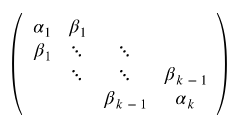

После приведения матрицы к соответствующему виду, собственные значения матрицы ищутся с помощью QR-алгоритма. 

В виду энергозатратности QR-алгоритма, я предоставила возможность пользователю определять, каким из двух обозначенных методов он хочет воспользоваться: QR-алгоритм или стандартная функция вычисления собственных значений numpy.lonalg.eigvals.

### Алгоритм:

#### Вход.
Обязательные данные: симметричная разреженная матрица $A$ порядка $n$ и размер преобразованной матрицы $k < n$.

Необязательные данные: вектор $c$ размера $n$, булевы переменные QR и lng.

#### Выход.
Без нахождения собственных значений: трехдиагональная симметричная матрица $T$.

С нахождением собственных значений: вектор собственных значений.

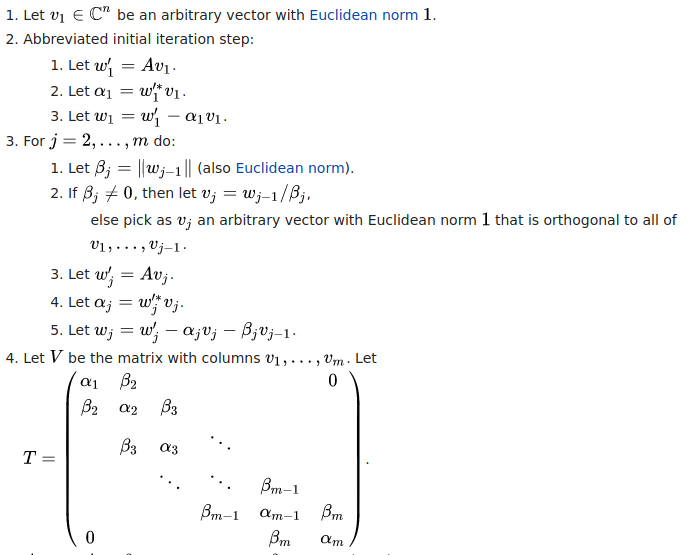

Евклидова норма:

In [7]:
def norm(x):
    s = 0
    for i in range(x.size[0]):
        for j in range(x.size[1]):
            s += x.matrix[i][j] ** 2
    return math.sqrt(s)

Вычисление векторов $\alpha$ и $\beta$:

In [8]:
def alpha_beta(A, c, k):
    w_ = []
    w = []
    a = []
    b = []
    v = []
    
    v.append(c.MultiNum(1 / norm(c)))
    w_.append(A.right_multiply(v[0]).make_Matrix())
    a.append(w_[0].Transpose().Multiply(v[0]))
    w.append(w_[0].Sum(v[0].MultiNum(-a[0])))
    
    for j in range(1, k):
        b.append(norm(w[j - 1]))
        if b[j - 1] != 0:
            v.append(w[j - 1].MultiNum(1 / b[j - 1]))
        else:
            #vj - ortho for all of vj-1
            break
        w_.append(A.right_multiply(v[j]).make_Matrix())
        a.append(w_[j].Transpose().Multiply(v[j]))
        w.append((w_[j].Sum(v[j].MultiNum(-a[j]))).Sum(v[j - 1].MultiNum(-b[j - 1])))
    
    return a, b

Построение матрицы $T$:

In [9]:
def make_T(a, b):
    cols = []
    k = 0
    for i in range(len(a)):
        rows = []
        for j in range(len(a)):
            if i == j:
                rows.append(a[i])
            elif (j == i + 1): 
                rows.append(b[k])
            elif (i == j + 1):
                rows.append(b[k])
                k += 1
            else:
                rows.append(0)
        cols.append(rows)
    return cols

Метод Ланцоша:

In [10]:
def Lanzosh(A, k, c=None, QR=False, lng=False):
    t1 = time.time()
    print('Alghorithm starts with matrix of size {}'.format(A.size))
    
    if k >= A.size[0]:
        raise Exception("k >= n")
    if A.simmetric() == False:
        raise Exception('Матрица должна быть симметричной')
    if c != None:
        if c.size[0] != A.size[1]:
            raise Exception('Несоответствие размерностей')
    else:
        c = Matrix([[random.uniform(0, 1)] * A.size[1]]).Transpose()
    
    a, b = alpha_beta(A, c, k)
    T = make_T(a, b)
    if QR == True:
        print('Finding eigvals using QR method')
        res = matrix.QR_values(Matrix(T))        
    elif lng == True:
        print('Finding eigvals using numpy.linalg')
        res = np.linalg.eigvals(np.array(T))        
    else:
        print('Only made the T-matrix')
        res = Matrix(T)
    t2 = time.time()
    print('Alghorithm finished with time: {}'.format(t2 - t1))        
    return res

## Работа алгоритма

Для наглядности и оценки погрешности работы алгоритма опишу функцию отрисовки истинных собственных значений исходной матрицы и собственных значений, вычисленных с помощью метода Ланцоша: 

In [11]:
def draw_eigvals(vals, vals_np, title, shift=None):
    
    # нормирую исходные векторы
    
    vals_x = vals / vals_np.std()
    vals_np_x = vals_np / vals_np.std()
    
    # делаю смещение для вычисленных собственных значений для наглядности
    
    if shift == None:
        shift = vals_np_x.mean() / 3
    
    vals_y = vals_x - shift
    
    fig = plt.figure(figsize=(20, 15))
    plt.grid()
    plt.title(title)
    
    # истинные значения голубые
    # вычисленные красные
    
    plt.scatter(vals_np_x, vals_np_x, color='blue')
    plt.scatter(vals_x, vals_y, color='red')
    
    # прорисовываю линии до истинных собственных
    # значений для наглядности погрешности
    
    for i in range(len(vals_x)):
        plt.plot([vals_x[i], vals_x[i]], [vals_y[i], vals_x[i]], color='black')
    
    
    plt.show()

### Матрица mat01

Для начала вычислю собственные значения помощью numpy:

In [12]:
v01_np = np.linalg.eigvals(m01)

In [13]:
v01_np

array([3.01517909e+09, 2.97042445e+09, 2.20795714e+09, 2.22059341e+09,
       2.01837279e+09, 1.78509475e+09, 1.85868190e+09, 1.85305648e+09,
       1.36181956e+09, 1.34516238e+09, 1.38707692e+09, 1.27594932e+09,
       1.11789149e+09, 1.00714595e+09, 1.02573248e+09, 8.95646366e+08,
       7.67471636e+08, 4.95671231e+08, 4.76982588e+08, 4.12018208e+08,
       5.83592414e+08, 5.79638662e+08, 8.55331049e+08, 8.56294941e+08,
       7.90257089e+06, 7.51001501e+06, 5.61803614e+06, 5.62290859e+06,
       4.76159380e+06, 3.38151095e+06, 3.94115653e+06, 4.37689917e+06,
       4.31780140e+06, 4.30841156e+06, 4.31040601e+06, 1.34246029e+06,
       6.03117808e+05, 6.63790645e+05, 6.60517175e+05, 6.55639383e+05,
       7.58394204e+04, 7.10638161e+04, 7.00900591e+04, 5.16340892e+04,
       2.23269914e+04, 3.41726756e+03, 1.08356555e+04, 8.97000982e+03])

Преобразую исходную матрицу в разреженную:

In [14]:
r_mat01 = R_matrix(mat=mat01)

Вычислю 10 собственных значений с помощью метода Ланцоша с использованием всех заложенных методов:

Alghorithm starts with matrix of size (48, 48)
Finding eigvals using QR method
Alghorithm finished with time: 19.779295444488525


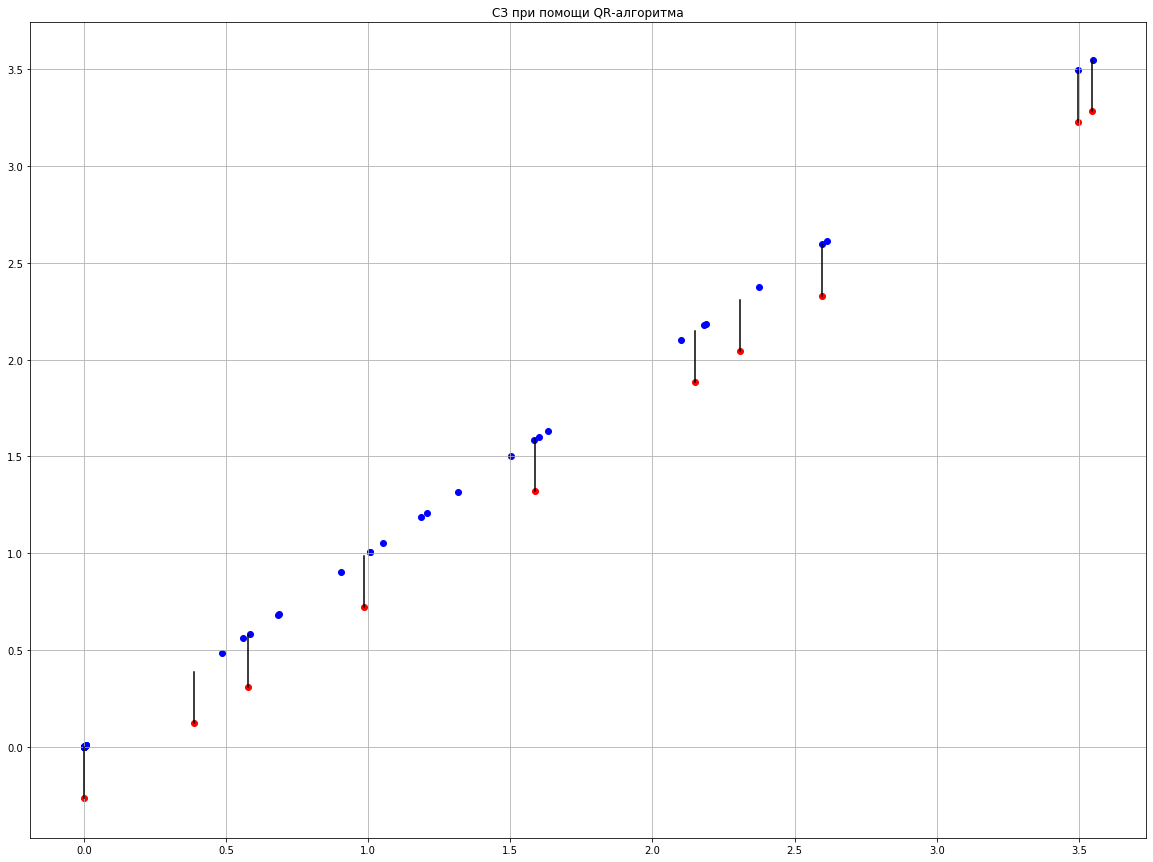

СЗ: [3015124595.269394, 2970351203.0898495, 2206228091.2439775, 1961017271.216633, 1827023730.2857416, 1349740576.8318908, 838558913.642088, 489286981.26312494, 329005129.69259, 295104.88284870744]

Alghorithm starts with matrix of size (48, 48)
Finding eigvals using numpy.linalg
Alghorithm finished with time: 0.011144638061523438


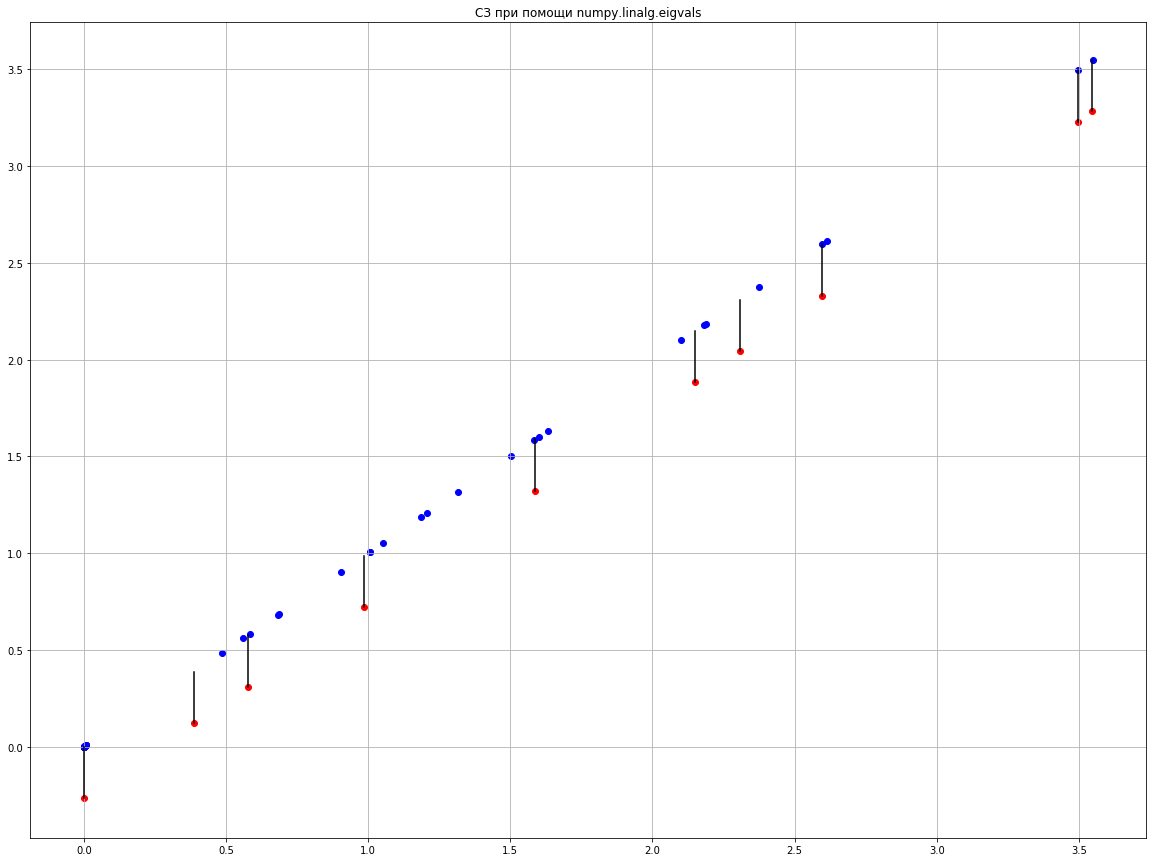

СЗ: [3.01512460e+09 2.97035120e+09 2.95104883e+05 3.29005130e+08
 4.89286981e+08 8.38558914e+08 1.34974058e+09 2.20622809e+09
 1.82702373e+09 1.96101727e+09]



In [15]:
meths = ['QR', 'lng']
k = 10

for m in meths:
    if m == 'QR':
        v01 = Lanzosh(r_mat01, k, QR=True)
        draw_eigvals(v01, v01_np, 'СЗ при помощи QR-алгоритма')
        print('СЗ: {}\n'.format(v01))
    if m == 'lng':
        v01 = Lanzosh(r_mat01, k, lng=True)
        draw_eigvals(v01, v01_np, 'СЗ при помощи numpy.linalg.eigvals')
        print('СЗ: {}\n'.format(v01))

Как видно по графику, погрешность в середине спектра может быть достаточно большой, но на краях метод достаточно точен, поэтому увеличу количество собственных значений до 15, чтобы проверить это:

Alghorithm starts with matrix of size (48, 48)
Finding eigvals using QR method
Alghorithm finished with time: 192.09887790679932


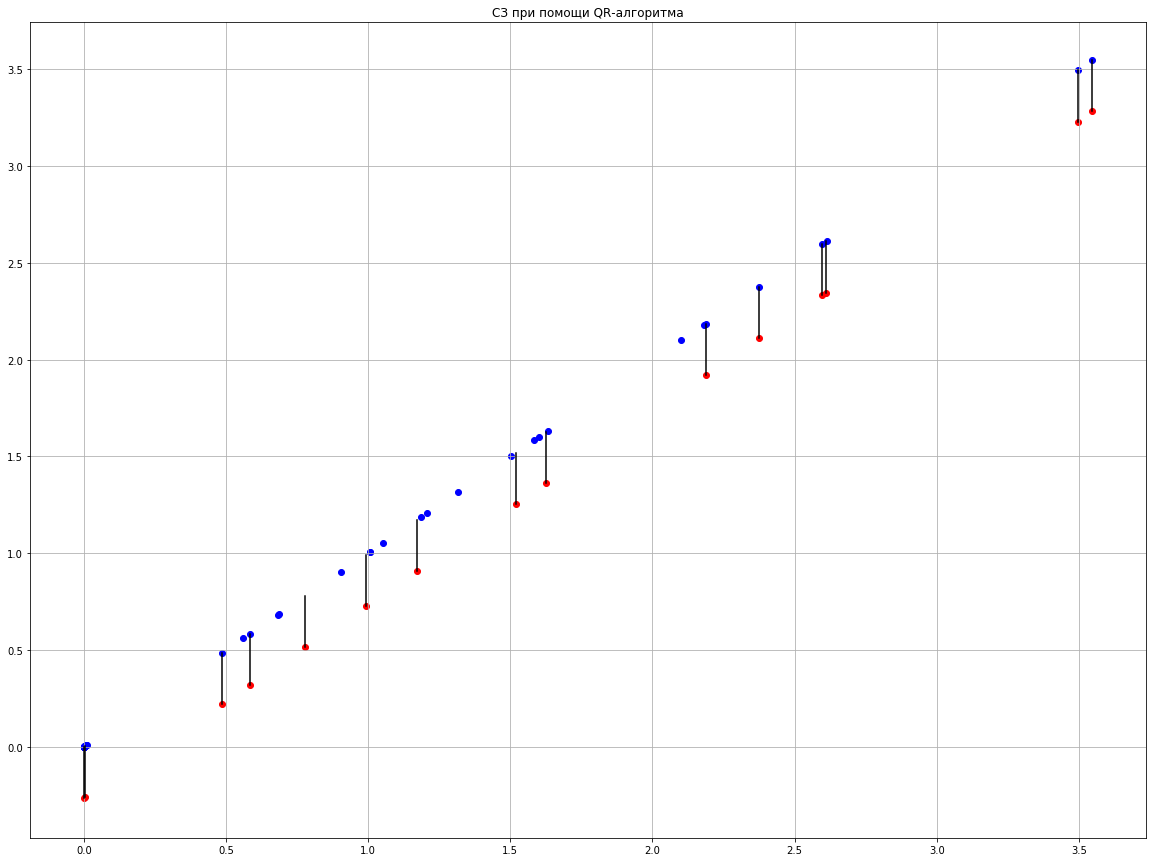

Alghorithm starts with matrix of size (48, 48)
Finding eigvals using numpy.linalg
Alghorithm finished with time: 0.07633209228515625


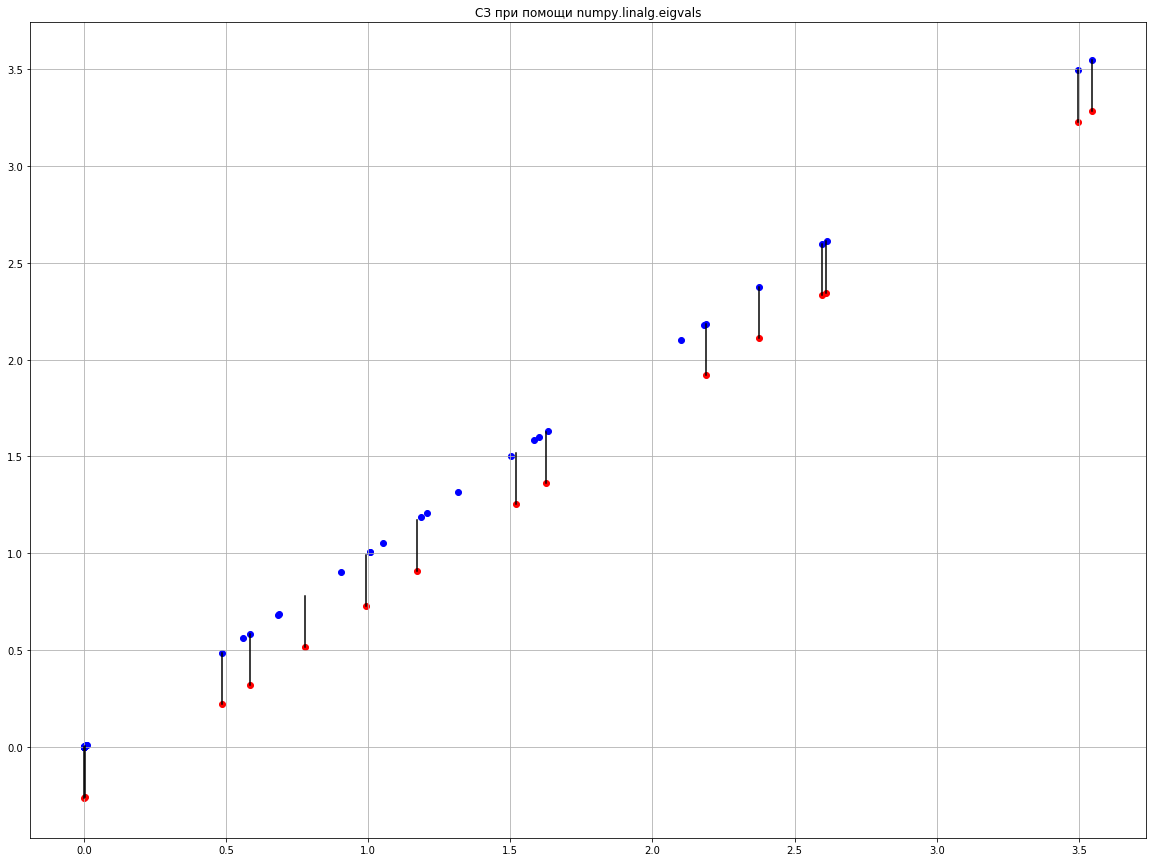

In [16]:
k = 15

for m in meths:
    if m == 'QR':
        v01 = Lanzosh(r_mat01, k, QR=True)
        draw_eigvals(v01, v01_np, 'СЗ при помощи QR-алгоритма')
    if m == 'lng':
        v01 = Lanzosh(r_mat01, k, lng=True)
        draw_eigvals(v01, v01_np, 'СЗ при помощи numpy.linalg.eigvals')

#### Так как неоптимизированный QR-алгоритм слишком затратный по времени, дальнейшие вычисления буду проводить с помощью numpy.

## Матрица mat04

Найду собственные значения с помощью numpy:

In [17]:
v04_np = np.linalg.eigvals(m04)

Преобразую матрицу в разреженную:

In [18]:
r_mat04 = R_matrix(mat=mat04)

Найду 20 и 40 собственных значений:

Alghorithm starts with matrix of size (132, 132)
Finding eigvals using numpy.linalg
Alghorithm finished with time: 0.09907317161560059


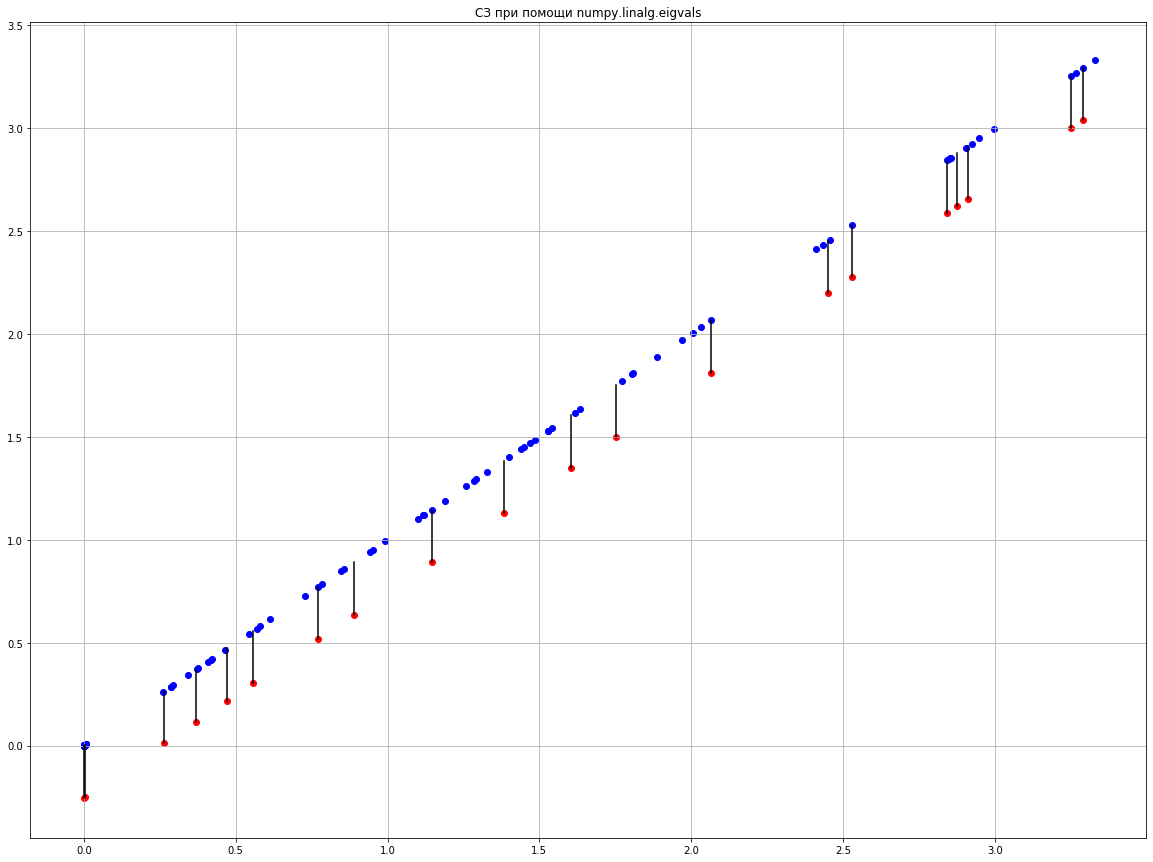

Alghorithm starts with matrix of size (132, 132)
Finding eigvals using numpy.linalg
Alghorithm finished with time: 0.14931869506835938


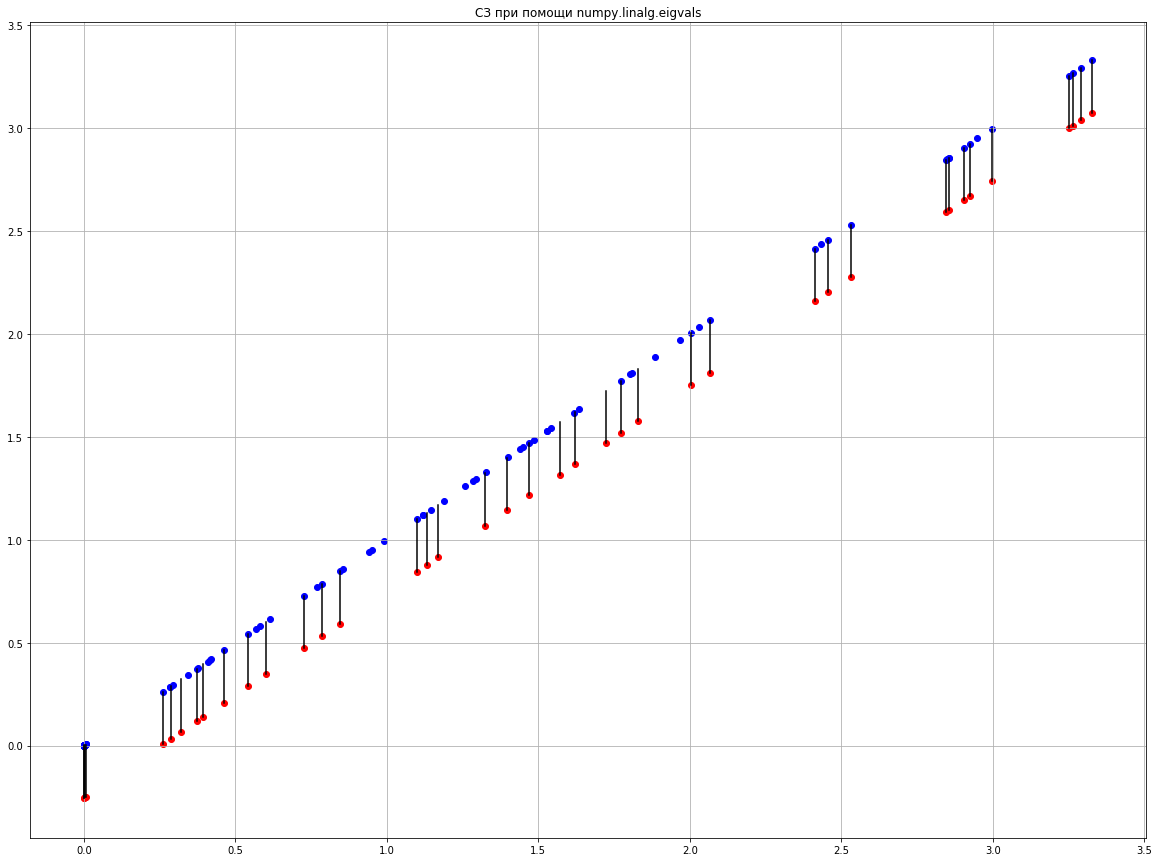

In [19]:
v04 = Lanzosh(r_mat04, 20, lng=True)
draw_eigvals(v04, v04_np, 'СЗ при помощи numpy.linalg.eigvals')

v04 = Lanzosh(r_mat04, 40, lng=True)
draw_eigvals(v04, v04_np, 'СЗ при помощи numpy.linalg.eigvals')

## Матрица mat26

Найду собственные значения с помощью numpy:

In [20]:
v26_np = np.linalg.eigvals(m26)

Преобразую матрицу в разреженную:

In [21]:
r_mat26 = R_matrix(mat=mat26)

Найду 40 собственных значений:

Alghorithm starts with matrix of size (1922, 1922)
Finding eigvals using numpy.linalg
Alghorithm finished with time: 6.2676050662994385


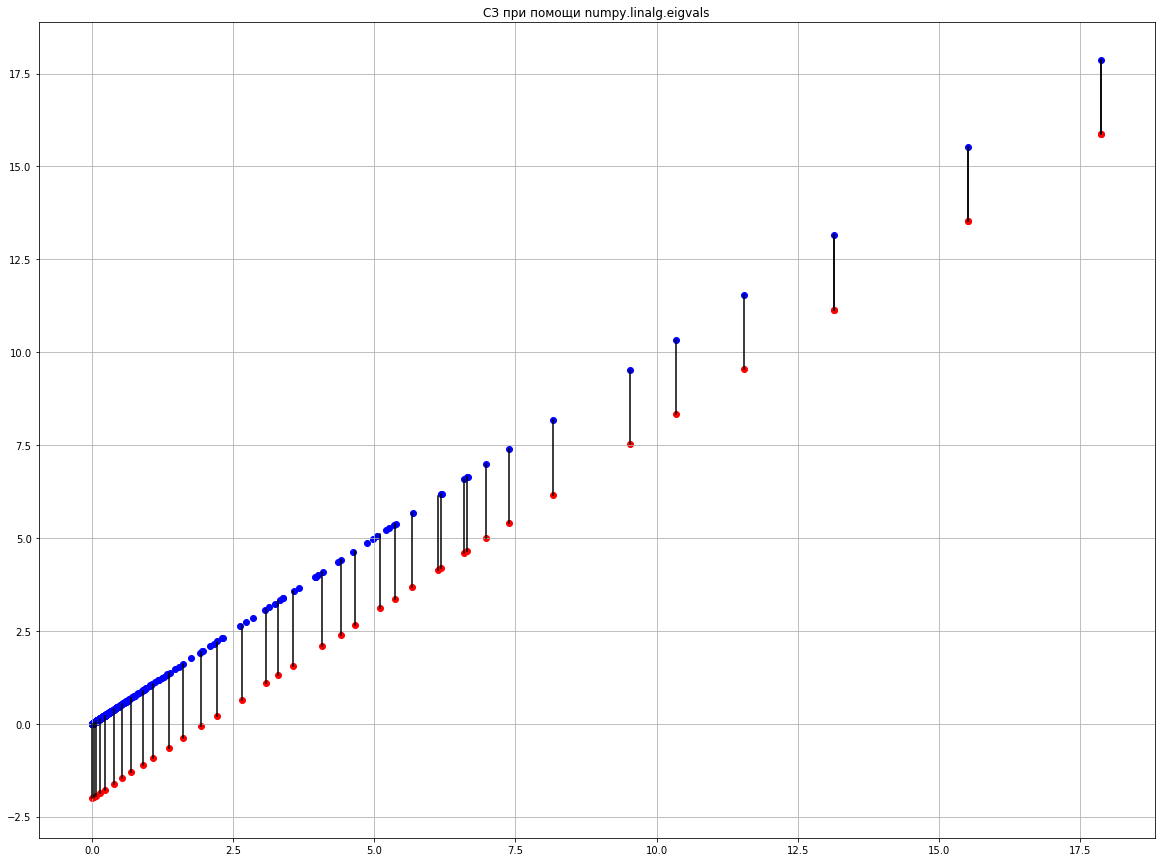

In [22]:
k = 40

v26 = Lanzosh(r_mat26, k, lng=True)
draw_eigvals(v26, v26_np, 'СЗ при помощи numpy.linalg.eigvals', shift=2)